In [5]:
import pandas as pd
import spacy
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier

import matplotlib.pyplot as plt 
import seaborn as sns

nlp = spacy.load("en_core_web_sm")


c:\Users\Ivana\anaconda3\lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.6.0) was trained with spaCy v3.6.0 and may not be 100% compatible with the current version (3.7.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## Data analysis and text (pre)processing

In [6]:
df = pd.read_csv("fake_or_real_news.csv")
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [7]:
df.label.value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

c:\Users\Ivana\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

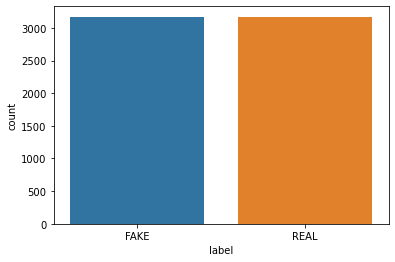

In [8]:
sns.countplot(df.label)

In [6]:
df['label_indx'] = df['label'].map({'FAKE':0, 'REAL':1})

In [7]:
df['text_title'] = df['title'] +' '+ df['text']
df.head()

,Unnamed: 0,title,text,label,label_indx,text_title
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0,You Can Smell Hillary’s Fear Daniel Greenfield...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0,Watch The Exact Moment Paul Ryan Committed Pol...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1,Kerry to go to Paris in gesture of sympathy U....
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0,Bernie supporters on Twitter erupt in anger ag...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1,The Battle of New York: Why This Primary Matte...


In [8]:
def text_cleaning(input):
    
    doc = nlp (input)

    filtered_tokens = []

    for token in doc:

        if token.is_digit or token.like_url or token.like_email or token.is_punct or token.is_stop or not token.is_alpha:
            continue

        filtered_tokens.append(token.lemma_.lower())

    return " ".join(filtered_tokens)

In [9]:
text_cleaning("https://t.co/VyTT49YvoE pic.twitter.com/wCvSCg4a5I \n — ABC News Politics ( @abcpolitic ) November 5")

'abc news politics november'

In [10]:
text_cleaning(df.text_title[1])

'watch exact moment paul ryan committed political suicide trump rally video google pinterest digg linkedin reddit stumbleupon print delicious pocket tumblr fundamental truth world paul ryan desperately want president paul ryan president today prove particularly staggering example political cowardice paul ryan reversed course announce trump train aboutface week ago previously declare support defend trump tape public trump brag assault woman suddenly ryan appear pro trump rally boldly declare send vote president united states surreal moment figurehead republican party dose gasoline get stage chilly afternoon wisconsin light match say vote republicans time come home abc news politics november democratic party ask well moment film ryan chance president go zero instant wreckage trump leave wake cravenly back campaign recover ryan career manage limp way dnc tape lock load ad election day ring endorsement man clearly hate personal level speak volume spinelessness ryan posture principled conse

In [11]:
import numpy as np

def text_cleaning_vec(input):
    text = text_cleaning(input)

    #print(text)
    doc = nlp (text)
    text_vec = [token.vector for token in doc if not token.is_digit and not token.is_punct]
    mean_vector = np.mean(text_vec, axis=0)
    
    return mean_vector

In [12]:
text_cleaning_vec("https://t.co/VyTT49YvoE pic.twitter.com/wCvSCg4a5I \n — ABC News Politics ( @abcpolitic ) November 5")

array([-0.35678035, -0.5682657 , -0.10119173,  0.1635158 ,  0.69081986,
       -0.5364157 ,  0.48210734,  0.9694538 ,  0.10484108,  0.06907815,
        0.42890966,  0.5223918 , -0.68166786, -1.1395869 ,  0.160749  ,
        0.8674704 , -1.0438187 , -0.4773293 ,  0.08452347, -0.15250188,
       -0.7270697 , -0.23994857, -0.7108637 , -0.01383007,  0.39712432,
        0.64373493,  0.11291176,  0.2399617 , -0.21520117,  0.5049225 ,
       -0.06799915, -0.23926604,  0.00365806,  0.6869439 , -0.3610528 ,
       -0.83756256,  0.35192084,  0.7636458 , -0.7756249 , -0.551648  ,
       -0.30343002, -0.05991395, -0.08851823,  1.2093204 , -0.42161483,
        0.438865  ,  0.27729803,  0.13899525, -0.40406653, -0.4149695 ,
       -0.11277638,  0.17811394,  0.9470813 , -0.47556204, -0.9983175 ,
       -0.10646421,  1.1210775 , -0.28398573,  1.0813371 ,  0.3340286 ,
       -0.8121162 , -0.7908784 ,  0.31200123, -1.4452287 , -0.28095084,
        0.12381858, -0.115339  ,  0.28564492, -0.33975708,  0.20

In [13]:
df['content_token'] = df['text_title'].apply(text_cleaning)

In [14]:
df['contect_vec'] = df['text_title'].apply(text_cleaning_vec)

In [15]:
df = df.drop(['text', 'Unnamed: 0'], axis = 1)

In [16]:
df.head()

,title,label,label_indx,text_title,content_token,contect_vec
0,You Can Smell Hillary’s Fear,FAKE,0,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary fear daniel greenfield shillman ...,"[0.025223581, -0.8577815, 0.07320459, 0.167341..."
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE,0,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan committed politic...,"[0.112266034, -0.8075179, 0.058862157, -0.0013..."
2,Kerry to go to Paris in gesture of sympathy,REAL,1,Kerry to go to Paris in gesture of sympathy U....,kerry paris gesture sympathy secretary state j...,"[-0.118559405, -0.89069813, 0.020497072, 0.116..."
3,Bernie supporters on Twitter erupt in anger ag...,FAKE,0,Bernie supporters on Twitter erupt in anger ag...,bernie supporter twitter erupt anger dnc try w...,"[0.05338322, -0.8572917, -0.020577673, 0.08491..."
4,The Battle of New York: Why This Primary Matters,REAL,1,The Battle of New York: Why This Primary Matte...,battle new york primary matter primary day new...,"[0.09442351, -0.9466966, 0.17027685, 0.0806112..."


In [17]:
df.contect_vec.isnull().value_counts()

False    6335
Name: contect_vec, dtype: int64

## Spliting data into the train and test set

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df.contect_vec.values,
    df.label_indx,
    test_size=0.2,
    random_state=2022
)

In [19]:
import numpy as np

X_train_2d = np.stack(X_train)  # i onda treba biti reshape jer imamo array u array pa da bude jedan array moramo napraviti stack
X_test_2d =  np.stack(X_test)

print("Shape of X_train after reshaping: ", X_train_2d.shape)
print("Shape of X_test after reshaping: ", X_test_2d.shape)

Shape of X_train after reshaping:  (5068, 96)
Shape of X_test after reshaping:  (1267, 96)


## Model train & prediction using wordvec

- Naive Bayes Classifier

In [20]:
model = GradientBoostingClassifier()
model.fit(X_train_2d,y_train)

GradientBoostingClassifier()

              precision    recall  f1-score   support

           0       0.77      0.73      0.75       634
           1       0.74      0.78      0.76       633

    accuracy                           0.75      1267
   macro avg       0.75      0.75      0.75      1267
weighted avg       0.75      0.75      0.75      1267

[[462 172]
 [141 492]]


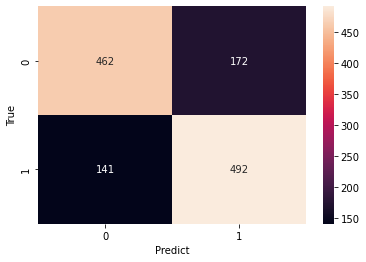

In [21]:
y_pred = model.predict(X_test_2d)
print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm,annot=True, fmt='d')
plt.ylabel('True')
plt.xlabel('Predict')

print(cm)

# Model train & prediction using bow, ngrams & tfidf

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    df.content_token,
    df.label_indx,
    test_size=0.2,
    random_state=2022
)

In [24]:
clf = Pipeline([
    ('trigram', CountVectorizer(ngram_range=(1,3))),
    ('naive b', MultinomialNB())
])

clf.fit(X_train, y_train)

Pipeline(steps=[('trigram', CountVectorizer(ngram_range=(1, 3))),
                ('naive b', MultinomialNB())])

              precision    recall  f1-score   support

           0       0.98      0.78      0.87       634
           1       0.81      0.99      0.89       633

    accuracy                           0.88      1267
   macro avg       0.90      0.88      0.88      1267
weighted avg       0.90      0.88      0.88      1267

[[492 142]
 [  8 625]]


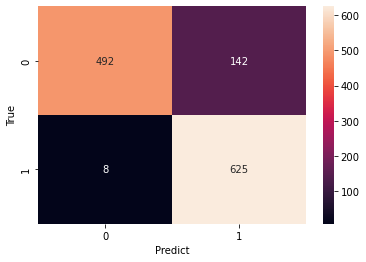

In [25]:
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm,annot=True, fmt='d')
plt.ylabel('True')
plt.xlabel('Predict')

print(cm)

In [26]:
clf = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('naive b', MultinomialNB())
])

clf.fit(X_train, y_train)

Pipeline(steps=[('tf_idf', TfidfVectorizer()), ('naive b', MultinomialNB())])

              precision    recall  f1-score   support

           0       0.97      0.69      0.81       634
           1       0.76      0.98      0.86       633

    accuracy                           0.84      1267
   macro avg       0.86      0.84      0.83      1267
weighted avg       0.86      0.84      0.83      1267



Text(0.5, 15.0, 'Predict')

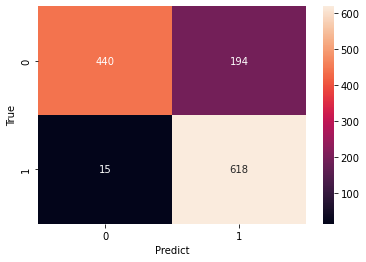

In [27]:
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm,annot=True, fmt='d')
plt.ylabel('True')
plt.xlabel('Predict')

In [28]:
clf = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('forest', RandomForestClassifier())
])

clf.fit(X_train, y_train)

Pipeline(steps=[('tf_idf', TfidfVectorizer()),
                ('forest', RandomForestClassifier())])

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       634
           1       0.91      0.89      0.90       633

    accuracy                           0.90      1267
   macro avg       0.90      0.90      0.90      1267
weighted avg       0.90      0.90      0.90      1267



Text(0.5, 15.0, 'Predict')

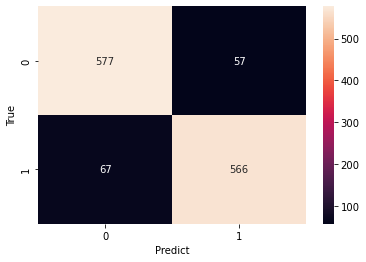

In [29]:
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm,annot=True, fmt='d')
plt.ylabel('True')
plt.xlabel('Predict')

In [31]:
clf = Pipeline([
    ('trigram', CountVectorizer(ngram_range=(1,3))),
    ('forest', RandomForestClassifier())
])

clf.fit(X_train, y_train)

Pipeline(steps=[('trigram', CountVectorizer(ngram_range=(1, 3))),
                ('forest', RandomForestClassifier())])

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       634
           1       0.89      0.88      0.88       633

    accuracy                           0.88      1267
   macro avg       0.88      0.88      0.88      1267
weighted avg       0.88      0.88      0.88      1267



Text(0.5, 15.0, 'Predict')

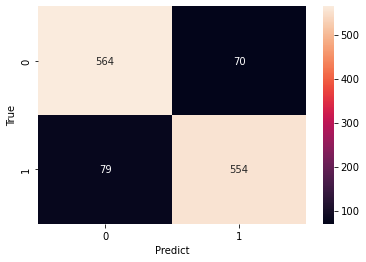

In [32]:
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm,annot=True, fmt='d')
plt.ylabel('True')
plt.xlabel('Predict')

In [33]:
clf = Pipeline([
    ('tf_idf', TfidfVectorizer()),
    ('log regreson', LogisticRegression())
])

clf.fit(X_train, y_train)

Pipeline(steps=[('tf_idf', TfidfVectorizer()),
                ('log regreson', LogisticRegression())])

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       634
           1       0.92      0.89      0.91       633

    accuracy                           0.91      1267
   macro avg       0.91      0.91      0.91      1267
weighted avg       0.91      0.91      0.91      1267



Text(0.5, 15.0, 'Predict')

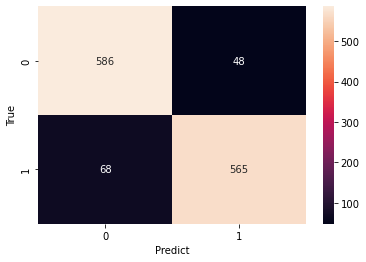

In [34]:
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm,annot=True, fmt='d')
plt.ylabel('True')
plt.xlabel('Predict')

In [45]:
clf = Pipeline([
    ('bow,', CountVectorizer(ngram_range=(1,3))),
    ('log regreson', LogisticRegression(max_iter=300))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('bow,', CountVectorizer(ngram_range=(1, 3))),
                ('log regreson', LogisticRegression(max_iter=300))])

              precision    recall  f1-score   support

           0       0.90      0.93      0.92       634
           1       0.93      0.90      0.91       633

    accuracy                           0.92      1267
   macro avg       0.92      0.92      0.92      1267
weighted avg       0.92      0.92      0.92      1267



Text(0.5, 15.0, 'Predict')

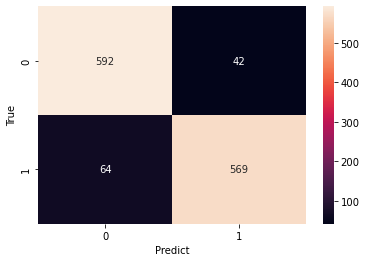

In [46]:
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm,annot=True, fmt='d')
plt.ylabel('True')
plt.xlabel('Predict')